Neural-ODE-related scripts from/based on:

https://github.com/emptymalei/deep-learning/blob/main/dl/notebooks/neuralode_timeseries.py

# Installs & Imports

In [1]:
!pip install -q duckdb torchdyn lightning torchmetrics loguru

In [2]:
import dataclasses
from typing import Dict, List, Tuple
from functools import cached_property
import torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import duckdb
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchdyn.core import NeuralODE
from zipfile import ZipFile
import tensorflow as tf
from loguru import logger
from torchmetrics import MetricCollection
from torchmetrics.regression import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
    SymmetricMeanAbsolutePercentageError,
)

# Load the Data

In [3]:
def load_jena_climate_data():
    """
    Function to download, extract, and load the Jena Climate Dataset.

    Returns:
        pd.DataFrame: The loaded dataset as a Pandas DataFrame.
    """
    # Download the dataset from the source
    uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
    zip_path = tf.keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")

    # Extract the downloaded ZIP file
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

    # Load the extracted CSV file into a DataFrame
    csv_path = "jena_climate_2009_2016.csv"
    jena_climate_data = pd.read_csv(csv_path)

    # Return the loaded dataset
    return jena_climate_data

In [4]:
# Load the dataset
jena_climate_data = load_jena_climate_data()

# Display the dataset
jena_climate_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def clean_jena_climate_data(df):
    # Convert the 'Date Time' column to a proper datetime object
    df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

    # Set 'Date Time' as the DataFrame index
    df = df.set_index('Date Time')

    # Resample to hourly intervals
    df = df.resample('1H').mean()

    # Forward fill for missing values
    df.ffill(inplace=True)

    # Check for data types
    for col in df.columns:
        if df[col].dtype == 'O':  # If the column is object type, try converting to float
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [6]:
# Clean the dataset
jena_climate_data = clean_jena_climate_data(jena_climate_data)

# Display the cleaned DataFrame
jena_climate_data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


# Explore the Data

In [7]:
# Data summary
jena_climate_data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000,70129.000000
mean,989.218988,9.443238,283.485303,4.957345,76.043691,13.567247,9.533915,4.033251,6.022466,9.640322,1216.098184,1.699888,3.052834,174.776650
std,8.355479,8.409636,8.490648,6.724468,16.385976,7.720700,4.178587,4.872982,2.652588,4.229751,39.918750,62.323677,66.657256,73.206800
min,934.905000,-22.653333,250.970000,-24.601667,13.683333,0.980000,0.821667,0.000000,0.516667,0.828333,1084.358333,-9999.000000,-9999.000000,0.000000
25%,984.213333,3.368333,277.443333,0.238333,65.311667,7.783333,6.216667,0.875000,3.918333,6.286667,1187.555000,1.035000,1.816667,140.733333
50%,989.580000,9.401667,283.446667,5.230000,79.300000,11.810000,8.871667,2.191667,5.600000,8.973333,1213.863333,1.766667,3.003333,192.333333
75%,994.720000,15.455000,289.506667,10.061667,89.366667,17.586667,12.346667,5.288333,7.798333,12.478333,1242.726667,2.815000,4.700000,224.400000
max,1015.243333,37.038333,310.976667,23.016667,100.000000,62.943333,28.168333,45.195000,18.025000,28.661667,1392.175000,12.895000,20.015000,359.800000


In [8]:
# Reset the index to make 'Date Time' a column again for DuckDB
jena_climate_reset = jena_climate_data.reset_index()

# Initialize DuckDB and import the dataset into DuckDB's in-memory engine
con = duckdb.connect(database=':memory:')  # In-memory DuckDB instance

# Register the cleaned DataFrame in DuckDB
con.execute("CREATE OR REPLACE TABLE jena_climate AS SELECT * FROM jena_climate_reset")

In [9]:
# View summary statistics for temperature, pressure, and wind speed
summary_stats = con.execute("""
    SELECT
        MIN("T (degC)") AS min_temp,
        MAX("T (degC)") AS max_temp,
        AVG("T (degC)") AS avg_temp,
        MIN("p (mbar)") AS min_pressure,
        MAX("p (mbar)") AS max_pressure,
        AVG("p (mbar)") AS avg_pressure,
        MIN("wv (m/s)") AS min_wind_speed,
        MAX("wv (m/s)") AS max_wind_speed,
        AVG("wv (m/s)") AS avg_wind_speed
    FROM jena_climate
""").df()

summary_stats.index = ['Values']
summary_stats = summary_stats.round(3).T

print("Summary Statistics:")
display(summary_stats)

Summary Statistics:


,Values
min_temp,-22.653
max_temp,37.038
avg_temp,9.443
min_pressure,934.905
max_pressure,1015.243
avg_pressure,989.219
min_wind_speed,-9999.000
max_wind_speed,12.895
avg_wind_speed,1.700


In [10]:
# Find days with the highest temperature and wind speed
high_temp_days = con.execute("""
    SELECT "Date Time", "T (degC)", "wv (m/s)"
    FROM jena_climate
    WHERE "T (degC)" > 30
    LIMIT 5
""").df()

print("High Temperature Days (Above 30°C):")
display(high_temp_days)

High Temperature Days (Above 30°C):


,Date Time,T (degC),wv (m/s)
0,2009-08-16 15:00:00,30.095000,4.531667
1,2009-08-16 16:00:00,30.108333,4.438333
2,2009-08-20 12:00:00,30.273333,4.000000
3,2009-08-20 13:00:00,31.158333,3.548333
4,2009-08-20 14:00:00,32.238333,3.403333


In [11]:
# Monthly average temperature and wind speed
monthly_pivot = con.execute("""
    SELECT strftime('%Y-%m', "Date Time") AS month,
           AVG("T (degC)") AS avg_temp,
           AVG("wv (m/s)") AS avg_wind_speed
    FROM jena_climate
    GROUP BY month
    ORDER BY month
""").df()

print("Monthly Average Temperature and Wind Speed:")
display(monthly_pivot)

Monthly Average Temperature and Wind Speed:


,month,avg_temp,avg_wind_speed
0,2009-01,-3.627664,1.784572
1,2009-02,0.169950,2.045833
2,2009-03,3.989944,2.429601
3,2009-04,11.889757,1.853863
4,2009-05,13.433905,2.080842
...,...,...,...
92,2016-09,17.412662,1.528646
93,2016-10,8.760582,1.629884
94,2016-11,3.821819,2.058035
95,2016-12,2.003226,1.659088


# Prepare the Data

In [12]:
# Get time series of interest
df_jena = jena_climate_data.copy()
df_jena = df_jena[['T (degC)']]
df_jena.head()

,T (degC)
Date Time,
2009-01-01 00:00:00,-8.304000
2009-01-01 01:00:00,-8.065000
2009-01-01 02:00:00,-8.763333
2009-01-01 03:00:00,-8.896667
2009-01-01 04:00:00,-9.348333


In [13]:
# Scale the data
scaler = MinMaxScaler().set_output(transform='pandas')
df_jena['T (degC)'] = scaler.fit_transform(df_jena)
df_jena.head()

,T (degC)
Date Time,
2009-01-01 00:00:00,0.240391
2009-01-01 01:00:00,0.244395
2009-01-01 02:00:00,0.232696
2009-01-01 03:00:00,0.230462
2009-01-01 04:00:00,0.222895


In [14]:
class DataFrameDataset(Dataset):
    """
    A dataset from a pandas dataframe for time series forecasting.

    :param dataframe: input dataframe with a DatetimeIndex.
    :param history_length: number of past timesteps used as input.
    :param horizon: number of future timesteps to forecast.
    :param gap: gap between the input and the forecast window.
    """

    def __init__(self, dataframe: pd.DataFrame, history_length: int, horizon: int, gap: int = 0):
        super().__init__()
        self.dataframe = dataframe
        self.history_length = history_length
        self.horizon = horizon
        self.gap = gap
        self.dataframe_rows = len(self.dataframe)
        self.length = self.dataframe_rows - self.history_length - self.horizon - self.gap + 1

    def moving_slicing(self, idx: int, gap: int = 0) -> Tuple[np.ndarray, np.ndarray]:
        """
        Slices the data into input (X) and target (Y) sequences.

        :param idx: index for slicing.
        :param gap: gap between input history and prediction.
        :return: input and target sequences.
        """
        x = self.dataframe.iloc[idx: idx + self.history_length].values
        y = self.dataframe.iloc[
            idx + self.history_length + gap: idx + self.history_length + self.horizon + gap
        ].values
        return x, y

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get item by index or slice.

        :param idx: index of the item.
        :return: input and target sequences for a given index.
        """
        if idx >= self.length:
            raise IndexError("End of dataset")
        return self.moving_slicing(idx)

    def __len__(self) -> int:
        """Returns the total number of samples."""
        return self.length

    def _validate_dataframe(self) -> None:
        """Validates the input dataframe."""
        if not isinstance(self.dataframe.index, pd.core.indexes.datetimes.DatetimeIndex):
            raise TypeError(f"Expected DatetimeIndex, got {type(self.dataframe.index)}")

        if self.dataframe.isnull().values.any():
            logger.warning("Dataframe contains null values")

        if not self.dataframe.index.is_monotonic_increasing:
            logger.warning("Dataframe index is not sorted")

In [15]:
class DataFrameDataModule(pl.LightningDataModule):
    """
    LightningDataModule for loading time series data from a pandas dataframe.

    :param history_length: length of input history sequence.
    :param horizon: number of timesteps to forecast.
    :param dataframe: pandas dataframe containing the time series data.
    :param gap: gap between input and prediction sequences.
    :param test_fraction: fraction of the dataset to use for testing.
    :param val_fraction: fraction of the training set to use for validation.
    :param batch_size: batch size for dataloaders.
    :param num_workers: number of workers for the dataloaders.
    """

    def __init__(self, history_length: int, horizon: int, dataframe: pd.DataFrame, gap: int = 0,
                 test_fraction: float = 0.3, val_fraction: float = 0.1, batch_size: int = 32, num_workers: int = 0):
        super().__init__()
        self.history_length = history_length
        self.horizon = horizon
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.gap = gap
        self.test_fraction = test_fraction
        self.val_fraction = val_fraction
        self.num_workers = num_workers

        self.train_dataset, self.val_dataset = self.split_train_val(self.train_val_dataset)

    @cached_property
    def df_length(self) -> int:
        return len(self.dataframe)

    @cached_property
    def df_test_length(self) -> int:
        return int(self.df_length * self.test_fraction)

    @cached_property
    def df_train_val_length(self) -> int:
        return self.df_length - self.df_test_length

    @cached_property
    def train_val_dataframe(self) -> pd.DataFrame:
        return self.dataframe.iloc[:self.df_train_val_length]

    @cached_property
    def test_dataframe(self) -> pd.DataFrame:
        return self.dataframe.iloc[self.df_train_val_length:]

    @cached_property
    def train_val_dataset(self) -> DataFrameDataset:
        return DataFrameDataset(
            dataframe=self.train_val_dataframe,
            history_length=self.history_length,
            horizon=self.horizon,
            gap=self.gap,
        )

    @cached_property
    def test_dataset(self) -> DataFrameDataset:
        return DataFrameDataset(
            dataframe=self.test_dataframe,
            history_length=self.history_length,
            horizon=self.horizon,
            gap=self.gap,
        )

    def split_train_val(self, dataset: Dataset):
        """Splits the dataset into training and validation sets."""
        val_len = int(len(dataset) * self.val_fraction)
        train_len = len(dataset) - val_len  # Ensure the sum equals the total dataset length
        return torch.utils.data.random_split(dataset, [train_len, val_len])

    def train_dataloader(self) -> DataLoader:
        """Returns the training DataLoader."""
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=self.num_workers > 0,
        )

    def test_dataloader(self) -> DataLoader:
        """Returns the test DataLoader."""
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def val_dataloader(self) -> DataLoader:
        """Returns the validation DataLoader."""
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=self.num_workers > 0,
        )

    def predict_dataloader(self) -> DataLoader:
        """Returns the DataLoader for predictions."""
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=len(self.test_dataset),
            shuffle=False,
        )

In [16]:
# Set parameters
history_length = 72  # using 72 past hours
horizon = 24  # predicting the next 24 hours
gap = 0  # no gap between the history and prediction
batch_size = 32
test_fraction = 0.2
val_fraction = 0.1
num_workers = 7

# Initialize the DataModule for the Jena dataset
jena_data_module = DataFrameDataModule(
    history_length=history_length,
    horizon=horizon,
    dataframe=df_jena,
    gap=gap,
    test_fraction=test_fraction,
    val_fraction=val_fraction,
    batch_size=batch_size,
    num_workers=num_workers
)

# Define & Train Model

In [17]:
@dataclasses.dataclass
class TSNODEParams:
    """A dataclass to be served as our parameters for the model.

    :param hidden_widths: list of dimensions for the hidden layers
    """

    hidden_widths: List[int]
    time_span: torch.Tensor

In [18]:
class TSNODE(nn.Module):
    """NeuralODE for univaraite time series modeling.

    :param history_length: the length of the input history.
    :param horizon: the number of steps to be forecasted.
    :param ffn_params: the parameters for the NODE network.
    """

    def __init__(self, history_length: int, horizon: int, model_params: TSNODEParams):
        super().__init__()
        self.model_params = model_params
        self.history_length = history_length
        self.horizon = horizon

        self.time_span = model_params.time_span

        self.regulate_input = nn.Linear(
            self.history_length, self.model_params.hidden_widths[0]
        )

        self.hidden_layers = nn.Sequential(
            *[
                self._linear_block(dim_in, dim_out)
                for dim_in, dim_out in zip(
                    self.model_params.hidden_widths[:-1],
                    self.model_params.hidden_widths[1:],
                )
            ]
        )

        self.regulate_output = nn.Linear(
            self.model_params.hidden_widths[-1], self.history_length
        )

        self.network = nn.Sequential(
            *[self.regulate_input, self.hidden_layers, self.regulate_output]
        )

    @property
    def node_config(self):
        return dataclasses.asdict(self.ffn_params)

    def _linear_block(self, dim_in, dim_out):
        return nn.Sequential(*[nn.Linear(dim_in, dim_out), nn.ReLU()])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [19]:
class NODEForecaster(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

        self.neural_ode = NeuralODE(
            self.model.network,
            sensitivity="adjoint",
            solver="dopri5",
            atol_adjoint=1e-4,
            rtol_adjoint=1e-4,
        )
        self.time_span = self.model.time_span
        self.horizon = self.model.horizon

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(-1).type(self.dtype)
        y = y.squeeze(-1).type(self.dtype)

        t_, y_hat = self.neural_ode(x, self.time_span)
        y_hat = y_hat[-1, ..., -self.horizon :]

        loss = nn.functional.mse_loss(y_hat, y)
        self.log_dict({"train_loss": loss}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(-1).type(self.dtype)
        y = y.squeeze(-1).type(self.dtype)

        t_, y_hat = self.neural_ode(x, self.time_span)
        y_hat = y_hat[-1, ..., -self.horizon :]

        loss = nn.functional.mse_loss(y_hat, y)
        self.log_dict({"val_loss": loss}, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(-1).type(self.dtype)
        y = y.squeeze(-1).type(self.dtype)

        t_, y_hat = self.neural_ode(x, self.time_span)
        y_hat = y_hat[-1, ..., -self.horizon :]

        return x, y_hat

    def forward(self, x):
        x = x.squeeze(-1).type(self.dtype)
        t_, y_hat = self.neural_ode(x, self.time_span)
        y_hat = y_hat[-1, ..., -self.horizon :]
        return x, y_hat

In [20]:
# Initialize the NODE forecaster
ts_model_params = TSNODEParams(
    hidden_widths=[256],
    time_span=torch.linspace(0, 1, horizon + 1)
)

ts_node = TSNODE(
    history_length=history_length,
    horizon=horizon,
    model_params=ts_model_params
)

node_forecaster = NODEForecaster(model=ts_node)

# Initialize logger and trainer
logger_node = pl.pytorch.loggers.TensorBoardLogger(
    save_dir="lightning_logs",
    name="node_forecaster"
)

trainer_node = pl.Trainer(
    precision="32",
    max_epochs=10,
    min_epochs=5,
    logger=logger_node,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=2)]
)

# Train the model
trainer_node.fit(
    model=node_forecaster,
    datamodule=jena_data_module
)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | model      | TSNODE    | 37.2 K | train
1 | neural_ode | NeuralODE | 37.2 K | train
-------------------------------------------------
37.2 K    Trainable params
0         Non-trainable params
37.2 K    Total params
0.149     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | model      | TSNODE    | 37.2 K | train
1 | ne

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=5` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
class LastObservationForecaster(pl.LightningModule):
    """Spits out the forecasts using the last observation.

    :param horizon: horizon of the forecast.
    """

    def __init__(self, horizon: int):
        super().__init__()
        self.horizon = horizon

    def _last_observation(self, x: torch.Tensor) -> torch.Tensor:
        return x[..., -1:, :]

    def predict_step(
        self, batch: List, batch_idx: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        x, y = batch

        y_hat = self._last_observation(x)

        y_hat = y_hat.repeat(1, self.horizon, 1)

        return x.squeeze(-1), y_hat.squeeze(-1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.type(self.dtype)
        return (
            x.squeeze(-1),
            self._last_observation(x).repeat(1, self.horizon, 1).squeeze(-1),
        )

In [22]:
# Initialize the Naive forecaster
lobs_forecaster = LastObservationForecaster(horizon=horizon)

In [23]:
# Initialize Naive Trainer
trainer_naive = pl.Trainer(precision="64")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Evaluate the Results

In [24]:
# Predictions for NODE Forecaster
predictions_node = trainer_node.predict(
    model=node_forecaster,
    datamodule=jena_data_module
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
# Predictions for Naive Forecaster
predictions_naive = trainer_naive.predict(
    model=lobs_forecaster,
    datamodule=jena_data_module
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
class Evaluator:
    """Evaluate the predictions

    :param step: which prediction step to be evaluated.
    :param gap: gap between input history and target/prediction.
    """

    def __init__(self, step: int = 0, gap: int = 0):
        self.step = step
        self.gap = gap

    @staticmethod
    def get_one_history(
        predictions: List, idx: int, batch_idx: int = 0
    ) -> torch.Tensor:
        return predictions[batch_idx][0][idx, ...]

    @staticmethod
    def get_one_pred(predictions: List, idx: int, batch_idx: int = 0) -> torch.Tensor:
        return predictions[batch_idx][1][idx, ...]

    @staticmethod
    def get_y(predictions: List, step: int) -> List[torch.Tensor]:
        return [i[1][..., step] for i in predictions]

    def y(self, predictions: List, batch_idx: int = 0) -> torch.Tensor:
        return self.get_y(predictions, self.step)[batch_idx].detach()

    @staticmethod
    def get_y_true(dataloader: DataLoader, step: int) -> torch.Tensor:
        return [i[1].squeeze(-1)[..., step] for i in dataloader]

    def y_true(self, dataloader: DataLoader, batch_idx: int = 0) -> torch.Tensor:
        return self.get_y_true(dataloader, step=self.step)[batch_idx].detach()

    def get_one_sample(
        self, predictions: List, idx: int, batch_idx: int = 0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        return (
            self.get_one_history(predictions, idx, batch_idx),
            self.get_one_pred(predictions, idx, batch_idx),
        )

    def plot_one_sample(
        self, ax: mpl.axes.Axes, predictions: List, idx: int, batch_idx: int = 0
    ):
        history, pred = self.get_one_sample(predictions, idx, batch_idx)

        x_raw = np.arange(len(history) + len(pred) + self.gap)
        x_history = x_raw[: len(history)]
        x_pred = x_raw[len(history) + self.gap :]
        x = np.concatenate([x_history, x_pred])

        y = np.concatenate([history, pred])

        ax.plot(x, y, marker=".", label=f"input ({idx})")

        ax.axvspan(x_pred[0], x_pred[-1], color="orange", alpha=0.1)

    @property
    def metric_collection(self) -> MetricCollection:
        return MetricCollection(
            MeanAbsoluteError(),
            MeanAbsolutePercentageError(),
            MeanSquaredError(),
            SymmetricMeanAbsolutePercentageError(),
        )

    @staticmethod
    def metric_dataframe(metrics: Dict) -> pd.DataFrame:
        return pd.DataFrame(
            [{k: float(v) for k, v in metrics.items()}], index=["values"]
        ).T

    def metrics(
        self, predictions: List, dataloader: DataLoader, batch_idx: int = 0
    ) -> pd.DataFrame:
        truths = self.y_true(dataloader)
        preds = self.y(predictions, batch_idx=batch_idx)

        return self.metric_dataframe(self.metric_collection(preds, truths))

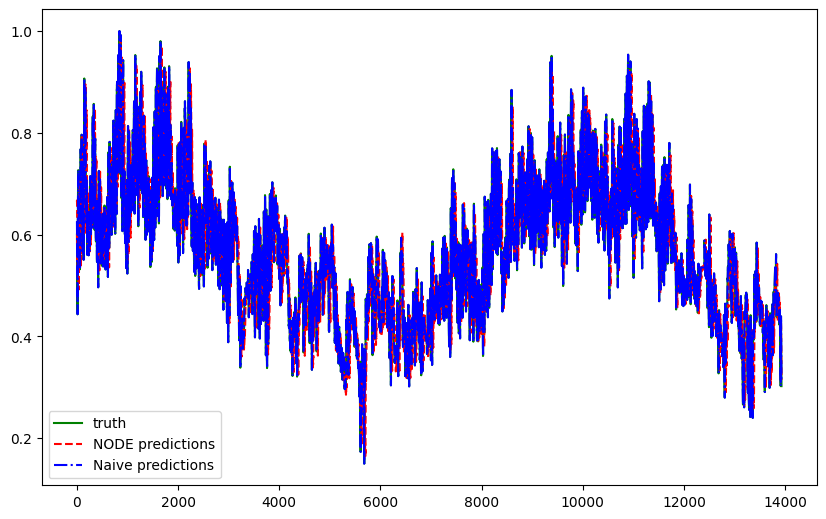

In [27]:
# Initialize the evaluator
evaluator = Evaluator(step=0, gap=gap)

# Plot truth and predictions
fig, ax = plt.subplots(figsize=(10, 6.18))

ax.plot(
    evaluator.y_true(dataloader=jena_data_module.predict_dataloader()),
    "g-",
    label="truth"
)

ax.plot(
    evaluator.y(predictions_node),
    "r--",
    label="NODE predictions"
)

ax.plot(
    evaluator.y(predictions_naive),
    "b-.",
    label="Naive predictions"
)

plt.legend()
plt.show()

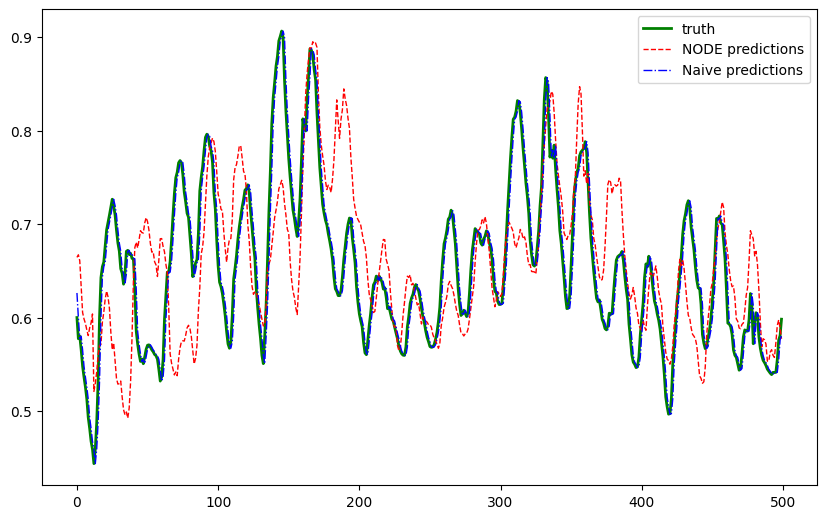

In [28]:
# Zoom in on a specific range of data points (first 500 points)
fig, ax = plt.subplots(figsize=(10, 6.18))

start_idx = 0
end_idx = 500

ax.plot(
    evaluator.y_true(dataloader=jena_data_module.predict_dataloader())[start_idx:end_idx],
    "g-",
    linewidth=2,
    label="truth"
)

ax.plot(
    evaluator.y(predictions_node)[start_idx:end_idx],
    "r--",
    linewidth=1,
    label="NODE predictions"
)

ax.plot(
    evaluator.y(predictions_naive)[start_idx:end_idx],
    "b-.",
    linewidth=1,
    label="Naive predictions"
)

plt.legend()
plt.show()

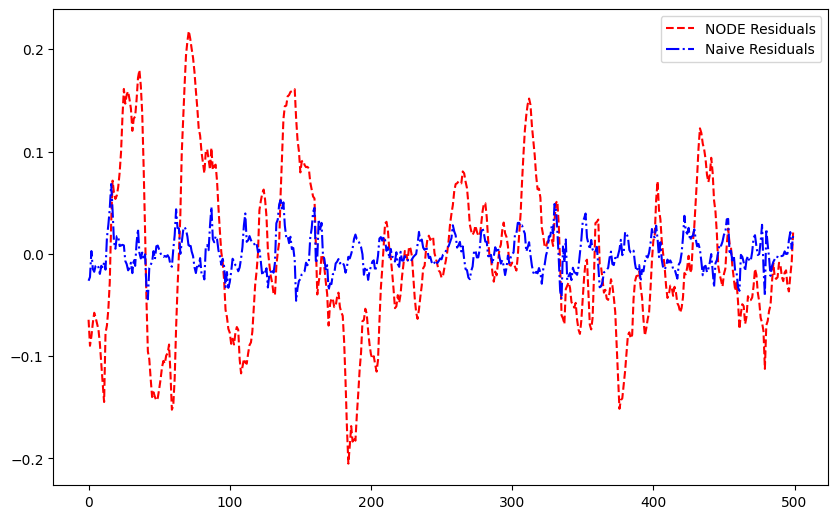

In [29]:
# Plot the error (residuals) between the true values and predictions
fig, ax = plt.subplots(figsize=(10, 6.18))

node_residuals = evaluator.y_true(dataloader=jena_data_module.predict_dataloader())[start_idx:end_idx] - evaluator.y(predictions_node)[start_idx:end_idx]
naive_residuals = evaluator.y_true(dataloader=jena_data_module.predict_dataloader())[start_idx:end_idx] - evaluator.y(predictions_naive)[start_idx:end_idx]

ax.plot(node_residuals, "r--", label="NODE Residuals")
ax.plot(naive_residuals, "b-.", label="Naive Residuals")

plt.legend()
plt.show()

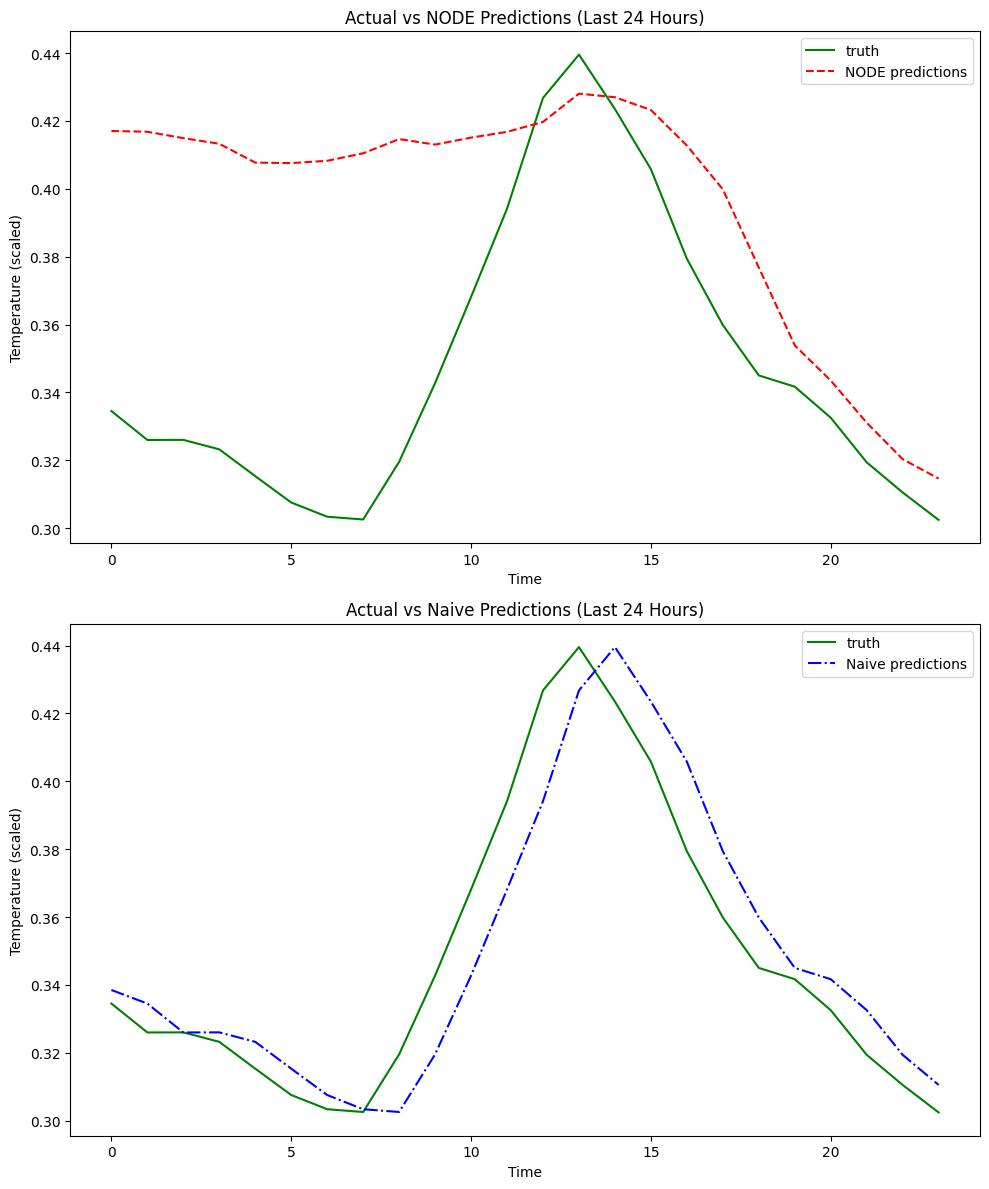

In [30]:
# Specify the subset of the data to plot
subset_start_idx = -24  # Plot the last 24 hours
subset_end_idx = None  # Until the end of the dataset

# Get true values and predictions for the subset
true_values = evaluator.y_true(dataloader=jena_data_module.predict_dataloader())[subset_start_idx:subset_end_idx]
node_predictions = evaluator.y(predictions_node)[subset_start_idx:subset_end_idx]
naive_predictions = evaluator.y(predictions_naive)[subset_start_idx:subset_end_idx]

# Create two subplots: one for NODE predictions, one for Naive predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 1: Actual values + NODE predictions
ax1.plot(true_values, "g-", label="truth")
ax1.plot(node_predictions, "r--", label="NODE predictions")
ax1.set_title("Actual vs NODE Predictions (Last 24 Hours)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (scaled)")
ax1.legend()

# Subplot 2: Actual values + Naive predictions
ax2.plot(true_values, "g-", label="truth")
ax2.plot(naive_predictions, "b-.", label="Naive predictions")
ax2.set_title("Actual vs Naive Predictions (Last 24 Hours)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Temperature (scaled)")
ax2.legend()

plt.tight_layout()
plt.show()

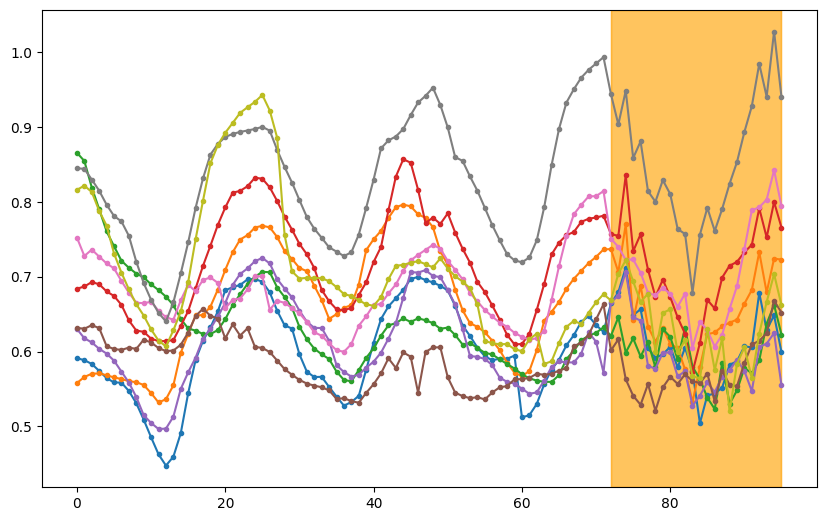

In [31]:
# Plot individual samples
fig, ax = plt.subplots(figsize=(10, 6.2))

for i in np.arange(0, 1000, 120):
    evaluator.plot_one_sample(ax=ax, predictions=predictions_node, idx=i)

plt.show()

In [32]:
# Display metrics
metrics_node = evaluator.metrics(predictions_node, jena_data_module.predict_dataloader())
metrics_naive = evaluator.metrics(predictions_naive, jena_data_module.predict_dataloader())

print("Metrics for NODE Forecaster:")
display(metrics_node)

print("\nMetrics for Naive Forecaster:")
display(metrics_naive)

Metrics for NODE Forecaster:


,values
MeanAbsoluteError,0.040006
MeanAbsolutePercentageError,0.074021
MeanSquaredError,0.002739
SymmetricMeanAbsolutePercentageError,0.073700



Metrics for Naive Forecaster:


,values
MeanAbsoluteError,0.011384
MeanAbsolutePercentageError,0.019929
MeanSquaredError,0.000251
SymmetricMeanAbsolutePercentageError,0.019987
